In [73]:
# This file is meant to verify the correctness of the implementation of the
# standardization of the data

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np


%matplotlib widget
# Load the data
base_dir = '/datasets/AddBiomechanics/processed_data/'

# Started to process
dataset = 'Falisse2017'
dataset = 'Wang2023'
dataset = 'vanderZee2022'
dataset = 'Tan2022'
dataset = 'Fregly2012'
dataset = 'Camargo2021'
dataset = 'Moore2015'
dataset = 'Hamner2013'

# Not started
dataset = 'Santos2017'
dataset = 'Tan2022'
dataset = 'Tan2021'
dataset = 'Han2023'
dataset = 'Tiziana2019'
dataset = 'Carter2023'


dataset = 'Falisse2017'
file_version = 'phase'
file_name = f'{base_dir}{dataset}_{file_version}.parquet'
data = pd.read_parquet(file_name)
data.columns

Index(['subject', 'task', 'frame_number', 'time_step', 'contact_r',
       'contact_l', 'grf_x_r', 'grf_y_r', 'grf_z_r', 'grf_x_l', 'grf_y_l',
       'grf_z_l', 'cop_x_r', 'cop_y_r', 'cop_z_r', 'cop_x_l', 'cop_y_l',
       'cop_z_l', 'pelvis_angle_s', 'pelvis_angle_f', 'pelvis_angle_t',
       'hip_angle_s_r', 'hip_angle_f_r', 'hip_angle_t_r', 'knee_angle_s_r',
       'ankle_angle_s_r', 'ankle_angle_t_r', 'hip_angle_s_l', 'hip_angle_f_l',
       'hip_angle_t_l', 'knee_angle_s_l', 'ankle_angle_s_l', 'ankle_angle_t_l',
       'dorsi_angle_r', 'dorsi_angle_l', 'shank_angle_r', 'shank_angle_l',
       'thigh_angle_r', 'thigh_angle_l', 'shank_vel_r', 'shank_vel_l',
       'thigh_vel_r', 'thigh_vel_l', 'ankle_vel_r', 'ankle_vel_l',
       'pelvis_vel_s', 'pelvis_vel_f', 'pelvis_vel_t', 'hip_vel_s_r',
       'hip_vel_f_r', 'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r',
       'ankle_vel_t_r', 'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l',
       'knee_vel_s_l', 'ankle_vel_s_l', 'ankle_vel_t_l'

In [74]:
data['subject'].unique()

array(['subject_5', 'subject_1', 'subject_9', 'subject_7'], dtype=object)

In [75]:
# Display all the tasks for 'subject5'
data['task'].unique()

array(['Gait_6', 'STS_1', 'STS_2', 'STS_4', 'STS_5', 'StairUp_4',
       'StairUp_5', 'Gait_10', 'Gait_7', 'Gait_9', 'STS_3', 'STS_6',
       'Gait_15', 'Gait_17', 'Gait_5'], dtype=object)

In [67]:

def convert_Santos2017(data):
    # TODO: Varun
    pass

def convert_Tan2022(data):
    # TODO: Varun
    pass

def convert_Tan2021(data):
    # TODO: Jiayi
    pass

def convert_Han2023(data):
    # TODO: Jiayi
    pass

def convert_Tiziana2019(data):
    # TODO: Varun
    pass

def convert_Carter2023(data):
    # todo: Jiayi
    pass


def convert_Hamner2013(df):
    # This dataset only contains running
    df['task_info'] = df['task']
    df['task'] = 'run'

    # Running speed is dependent on the integer value of the task
    # Tasks are 'run200', 'run300', 'run400', and 'run500'	
    df['walking_speed'] = None
    for i in range(2,6):
        df.loc[df['task_info'].str.contains(str(i)), 'walking_speed'] = float(i)
    # Verify that all the walking speeds have been set
    assert df['walking_speed'].isnull().sum() == 0, \
        'Not all walking speeds have been set for the Hamner2013 dataset'
    
    # Set the ground inclination to be zero 
    df['ground_inclination'] = 0


def convert_Moore2015(df):
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']

    # There's only level-ground walking in this dataset
    df['task'] = 'level_walking'

    # Add a list of the walking speeds
    # https://peerj.com/articles/918/ 
    # Table 1
    walking_speed_task_speed_list = [
        # [Task number, Speed (m/s)]
        # 0.8 m/s
        [[9,12,15,16,19,25,32,40,46,49,55,61,67,73,76],0.8],
        # 1.2 m/s
        [[10,13,17,20,26,31,41,47,50,56,62,68,74,77],1.2],
        # 1.6 m/s
        [[11,14,18,21,27,33,42,48,51,57,63,69,75,78],1.6],
    ]
    # Add a column called walking_speed
    df['walking_speed'] = None
    # Set the walking speed for each task
    for task_list,speed in walking_speed_task_speed_list:
        for task in task_list:
            # First, convert the task number to a string
            task_str = str(task)
            # Then, set the walking speed for the task
            df.loc[df['task_info'].str.contains(task_str), 
                   'walking_speed'] = speed

    # Verify that all the walking speeds have been set
    assert df['walking_speed'].isnull().sum() == 0, \
        'Not all walking speeds have been set for the Moore2015 dataset'



def convert_Camargo2021(df):
    # TODO:Varun
    # Add a column called task_info with additional information 
    # about the task.
    df['task_info'] = df['task']

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['treadmill', 'level_walking'],
        ['Treadmill', 'level_walking'],
        ['levelground', 'level_walking'],
        ['LevelGround', 'level_walking'],

        ['ramp', 'ramp'],
        ['Ramp', 'ramp'],

        ['stairs', 'stairs'],
        ['Stairs', 'stairs'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task


def convert_Fregly2012(df):
    # TODO:Varun
    # Keep th original task column as task_info 
    df['task_info'] = df['task']
    # Set the subject name as the first two characters of the task
    df['subject'] = df['task'].str[:2]
    # Remove the first three characters of the task name
    df['task_info'] = df['task_info'].apply(lambda x: x[3:])

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['ngait', 'level_walking'],              # Normal Gait
        
        ['mtpgait', 'modified_walking'],    # Medial Trus
        ['medthrust', 'modified_walking'],  # Medial Thrust
        ['mtgait', 'modified_walking'],     # Medial Thrust Gait

        ['wpgait', 'modified_walking'],     # Walking Pole
        ['tsgait', 'modified_walking'],     # Trunk Sway Gait
        
        ['mildcrouch', 'modified_walking'], # Mild Crouch Gait
        ['crouch_og', 'modified_walking'],  # Crouch Gait
        
        ['bouncy', 'modified_walking'],     # Bouncy Gait
        ['smooth', 'modified_walking'],     # Smooth Gait?
        ['rightturn', 'modified_walking'],  # Right Turn
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task

def convert_Tan2022(df):
    # TODO: Jiayi
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = None
    
    # This dataset only has running
    df['task'] = 'run'

def convert_vanderZee2022(df):
    # TODO: Jiayi
    # https://www.nature.com/articles/s41597-022-01817-1/tables/3
    # Has all the information for the speed, step length, step frequency, 
    # step width, and walking condition

    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    # Split the information from trial{number} to {number} (i.e. remove 
    # the word trial)
    df['task_info'] = df['task_info'].str.replace('trial', '')

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['trial', 'level_walking'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task


def convert_Wang2023(df):
    # TODO: Jose
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    
    # Create a list of the original tasks and the new task name 
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['walk',         'level_walking'],
        ['run',          'run'],
        ['static_pose',  'non_cyclic'],
        ['jump',         'non_cyclic'],
        ['lunge',        'non_cyclic'],
        ['squat',        'non_cyclic'],
        ['land',         'non_cyclic'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task

    # Add ground inclination
    df['ground_inclination'] = 0


def convert_Falisse2017(df):
    # TODO: Jose
    # Add a column called task_info with additional information 
    # about the task
    df['task_info'] = df['task']
    # Split the information in task info from {task}_{number} to {number}
    df['task_info'] = df['task_info'].str.split('_').str[1]

    # Create a list of the original tasks and the new task name
    # to be used for the conversion
    task_conversion_list = [
        # [Original task, New task]
        ['Gait', 'level_walking'],
        ['StairUp', 'up_stair'],
        ['StairDown', 'down_stair'],
        ['STS', 'sit-to-stand-to-sit'],
    ]
    # Convert the tasks to the same format as in the other datasets
    for old_task,new_task in task_conversion_list:
        df.loc[df['task'].str.contains(old_task), 'task'] = new_task



#convert_Fregly2012(data)
#data['subject'].unique()

# convert_Moore2015(data)
# print(data['subject'].unique())
# print(data['task'].unique())
# print(data['walking_speed'].unique())
# print(data['task_info'].unique())

In [68]:
def plot_features(data, features, axis):
    for leg in ['r', 'l']:
        leg_df = data[data['phase_leading_leg'] == leg]
        x = np.linspace(0, 1, 150)
        fig, ax = plt.subplots(len(axis), len(features), squeeze=False, 
                            # Figsize depending on the number of features
                            figsize=(len(features)*5, len(axis)*5))

        for feat_i, feature in enumerate(features):
            for ax_i, axi in enumerate(axis):
                data_name = feature + '_' + axi + '_' + leg
                # Average out the data
                d = leg_df[data_name].values.reshape(-1,150)
                d_avg = np.mean(d,axis=0)
                d_std = np.std(d,axis=0)
                ax[ax_i, feat_i].plot(x,d_avg, label=data_name)
                ax[ax_i, feat_i].fill_between(x, d_avg - d_std, d_avg + d_std, alpha=0.3)
                ax[ax_i, feat_i].set_title(data_name)
        plt.suptitle("Leg " + leg)
        plt.tight_layout()

/tmp/ipykernel_2341436/2091142643.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(len(axis), len(features), squeeze=False,


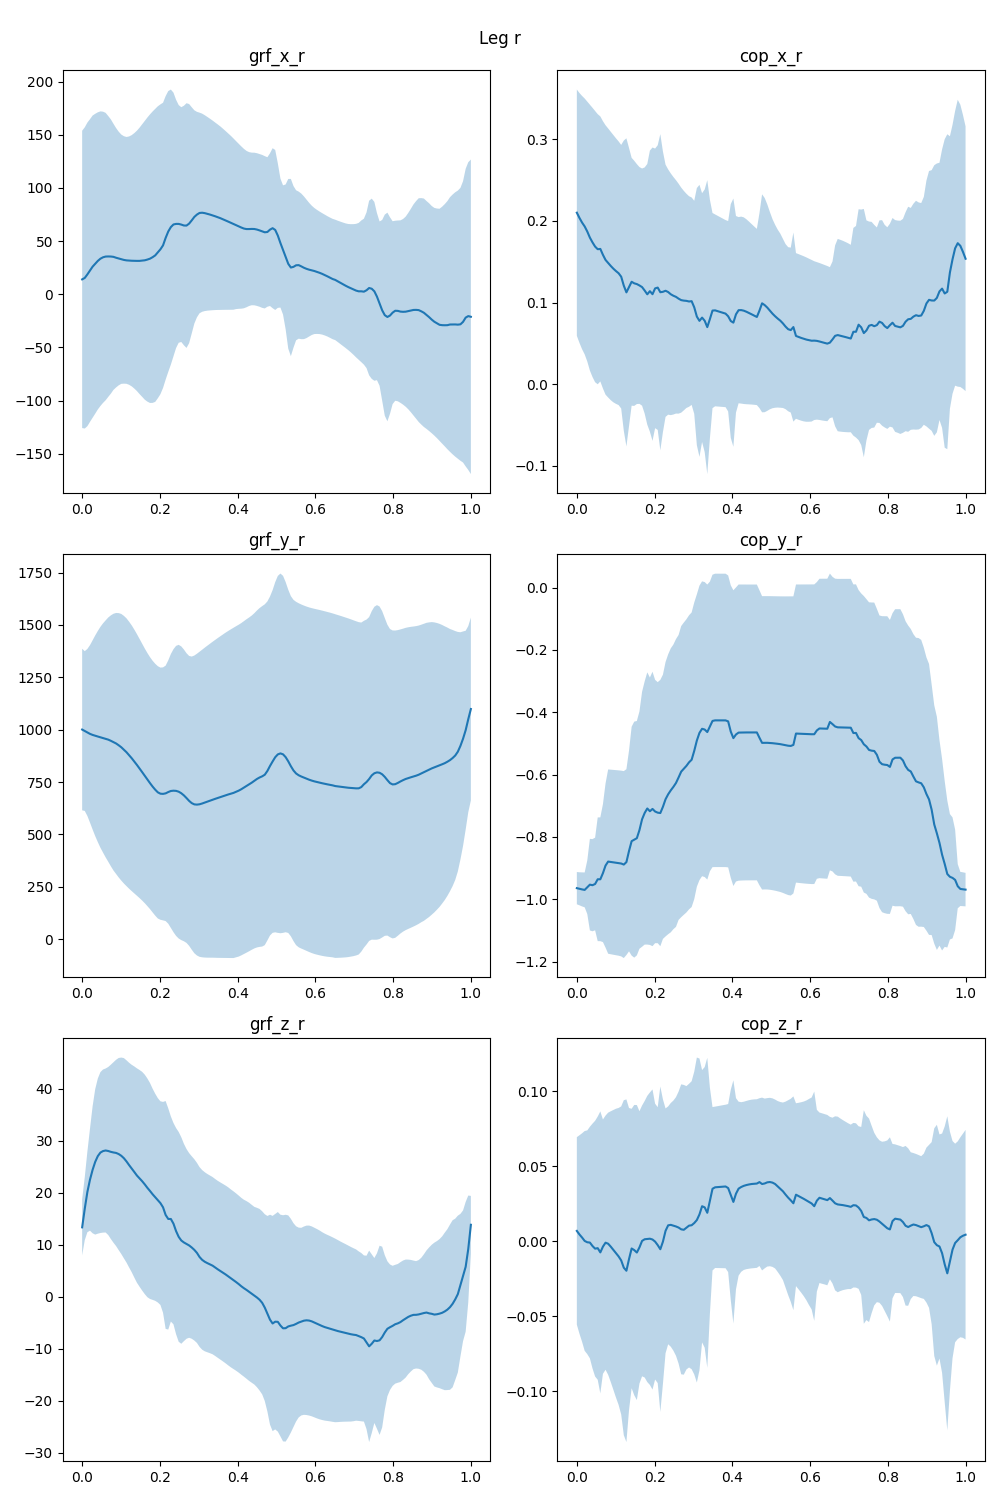

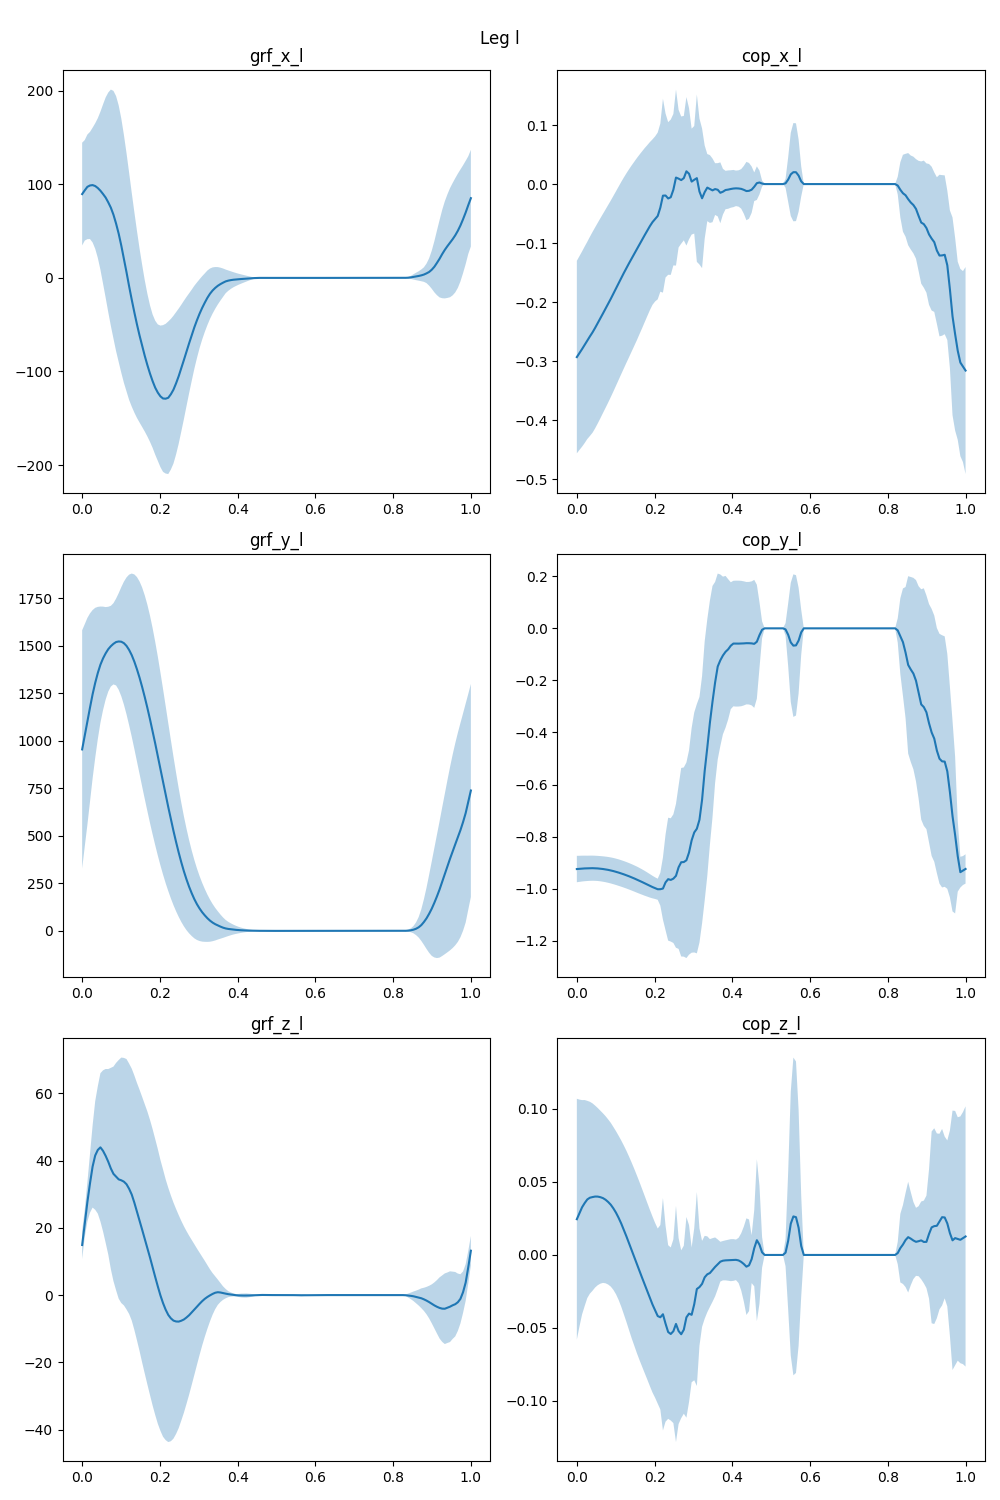

In [69]:
features = ['grf', 'cop']
axis = ['x', 'y', 'z']
plot_features(data, features, axis)

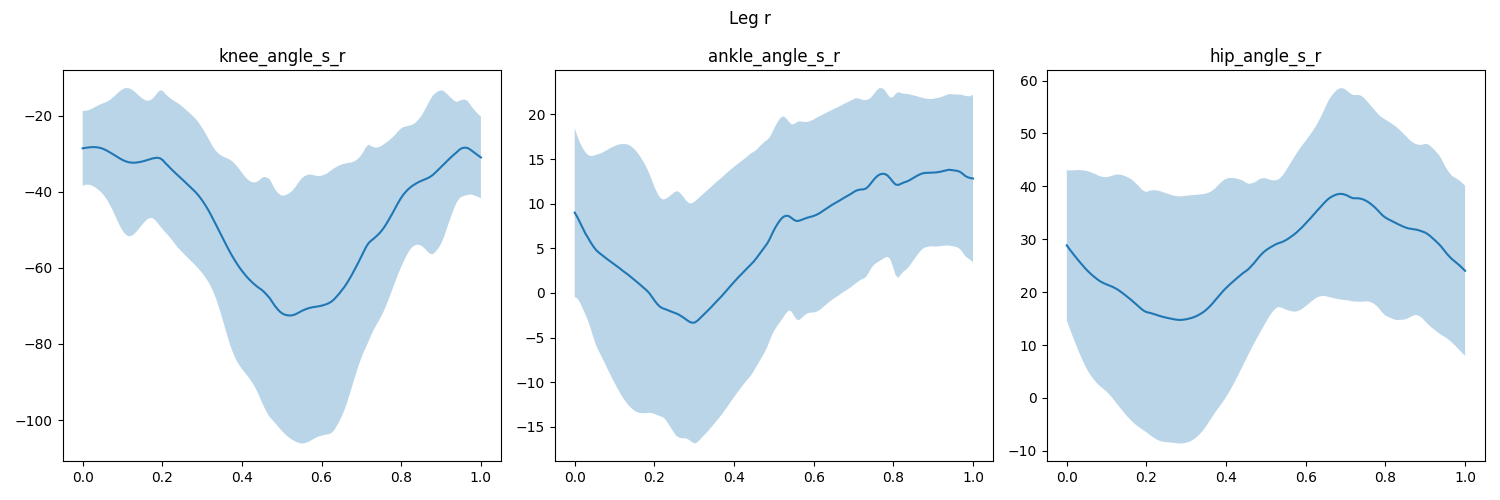

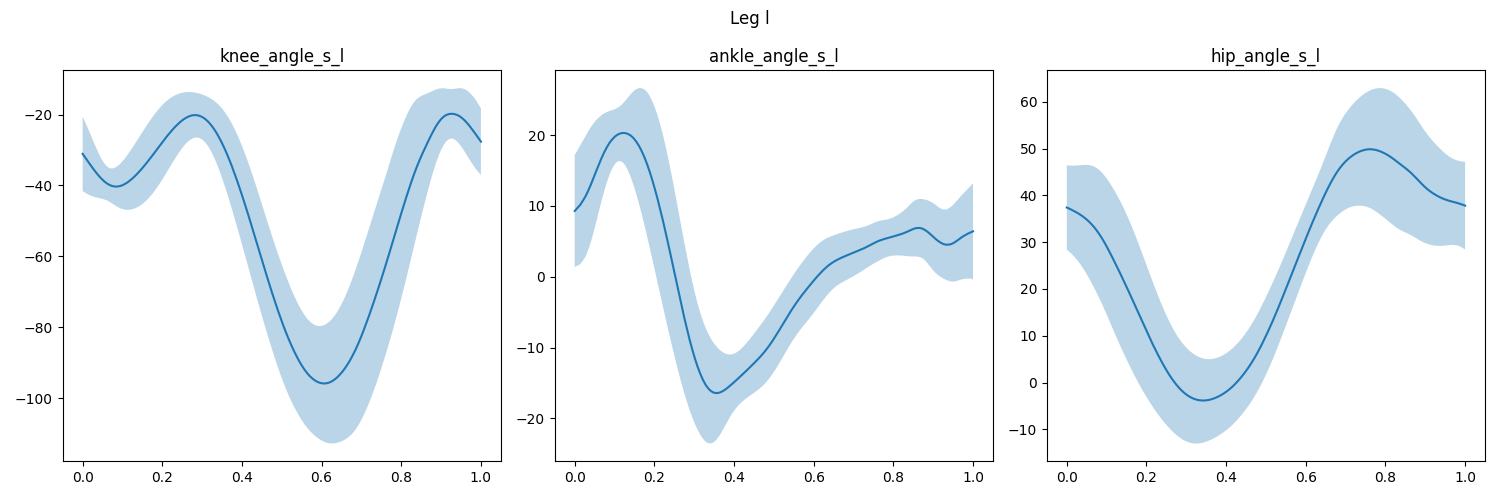

In [70]:
features = ['knee_angle', 'ankle_angle', 'hip_angle']
axis = ['s']
plot_features(data, features, axis)


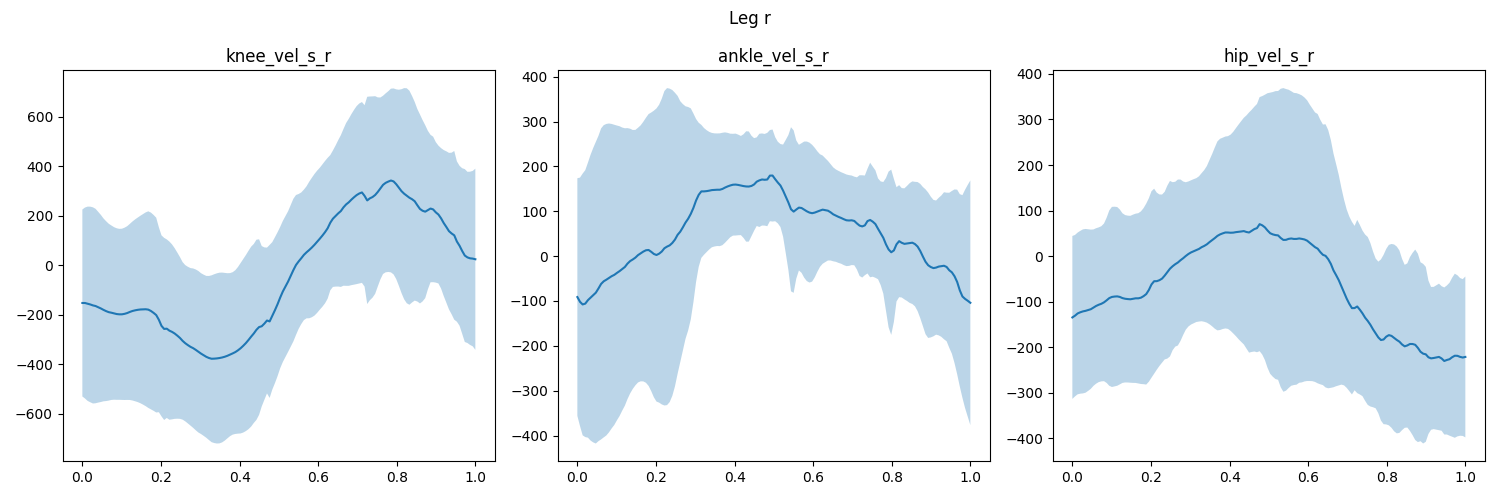

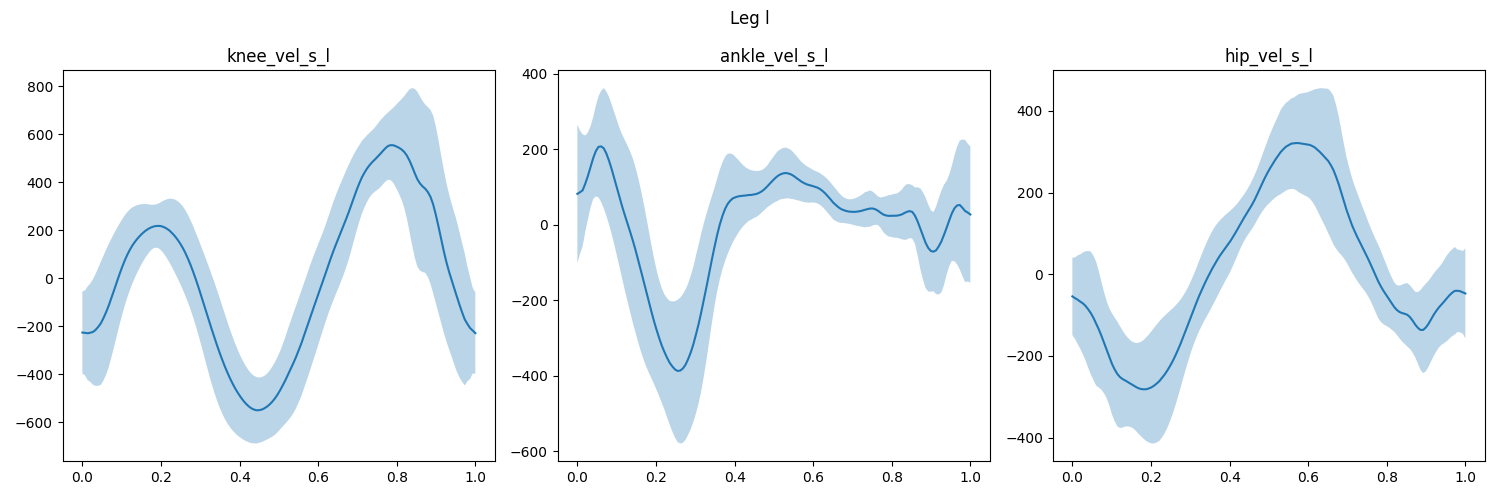

In [71]:
features = ['knee_vel', 'ankle_vel', 'hip_vel']
axis = ['s']
plot_features(data, features, axis)

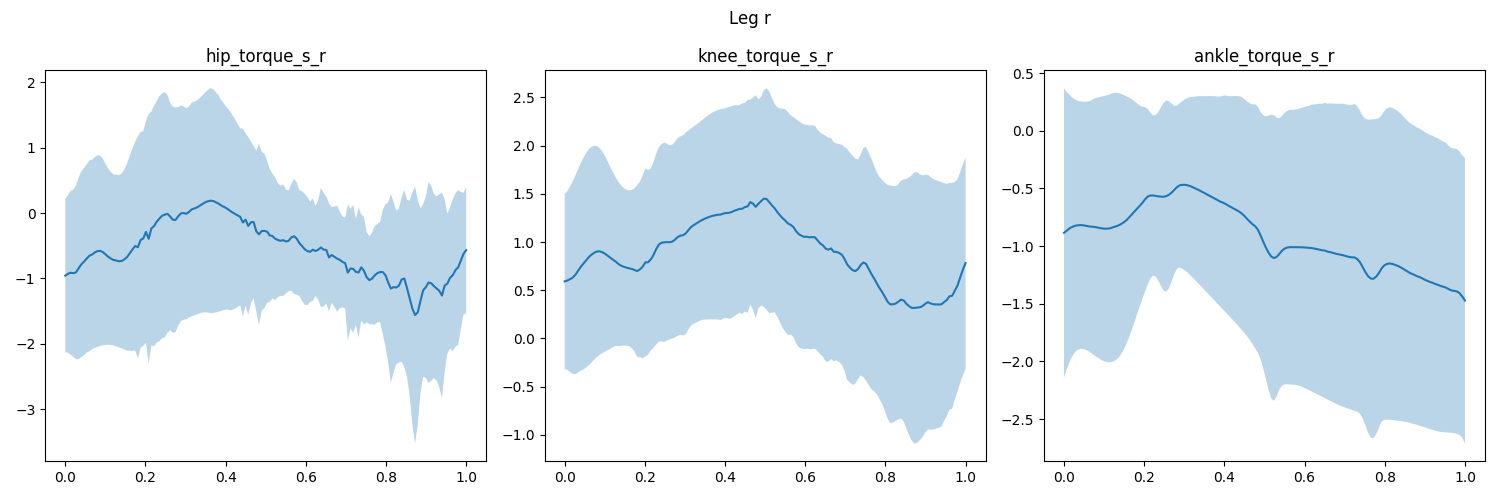

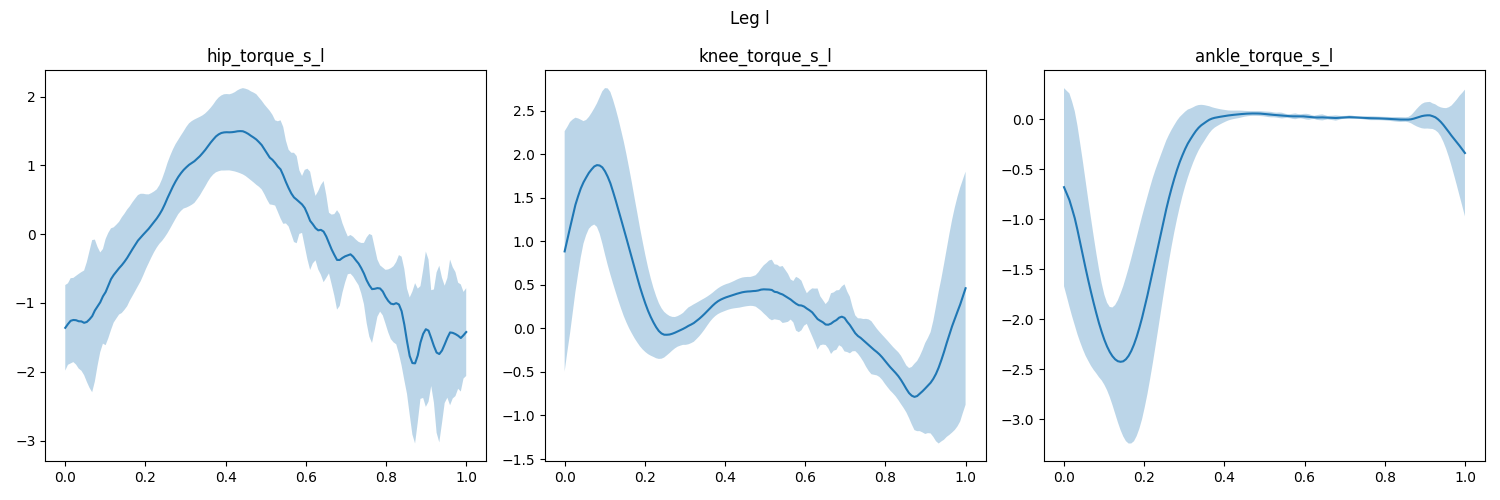

In [72]:
features = ['hip_torque', 'knee_torque', 'ankle_torque']
axis = ['s']
plot_features(data, features, axis)